In [1]:
# Install required packages if not already installed
import sys
import subprocess
import os

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

# Install required packages
install_package("vaderSentiment")
install_package("textblob")
install_package("scipy")


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score


In [3]:
import pandas as pd
import os

# Load the dataset - try multiple possible locations
possible_paths = [
    "/Users/abdullah/Desktop/HU Classes/GRAD699/Amazon_Data.csv",  # Where you said it is
    "/Users/abdullah/Desktop/HU Classes/GRAD699/Sentiment Analysis/Amazon_Data.csv",  # Actual location
    "../Amazon_Data.csv",  # Relative path from Week 2
    "Amazon_Data.csv",  # Current directory
]

# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    # For Colab, try drive paths
    possible_paths.extend([
        "/content/drive/MyDrive/Amazon_Data.csv",
        "/content/drive/MyDrive/GRAD699/Amazon_Data.csv",
        "/content/Amazon_Data.csv",
    ])
except:
    IN_COLAB = False

csv_path = None
for path in possible_paths:
    try:
        if os.path.exists(path) or (not IN_COLAB and path.startswith("/")):
            df = pd.read_csv(path)
            csv_path = path
            print(f"✓ Found file at: {path}")
            break
    except:
        continue

if csv_path is None:
    raise FileNotFoundError(
        f"Could not find Amazon_Data.csv. Tried:\n" + 
        "\n".join([f"  - {p}" for p in possible_paths[:4]])
    )

print(f"Dataset loaded: {len(df):,} rows, {len(df.columns)} columns")
print(f"Columns: {list(df.columns)}")
df.head()


✓ Found file at: /Users/abdullah/Desktop/HU Classes/GRAD699/Sentiment Analysis/Amazon_Data.csv
Dataset loaded: 701,528 rows, 10 columns
Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,True
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,True
2,5,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,2,True
3,1,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,0,True
4,5,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,0,True


In [4]:
# Data cleaning
df = df[['text', 'rating', 'timestamp']].dropna()

df = df.rename(columns={
    'text': 'text',
    'rating': 'rating',
    'timestamp': 'timestamp'
})

df.head()


,text,rating,timestamp
0,This spray is really nice. It smells really go...,5,2020-05-05 14:08:48.923
1,"This product does what I need it to do, I just...",4,2020-05-04 18:10:55.070
2,"Smells good, feels great!",5,2020-05-16 21:41:06.052
3,Felt synthetic,1,2022-01-28 18:13:50.220
4,Love it,5,2020-12-30 10:02:43.534


In [5]:
# Convert timestamp + hour
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Drop any rows with empty timestamp
df = df.dropna(subset=['timestamp'])

# Extract the hour of day (0–23)
df['review_hour'] = df['timestamp'].dt.hour

df.head()


,text,rating,timestamp,review_hour
0,This spray is really nice. It smells really go...,5,2020-05-05 14:08:48.923,14
1,"This product does what I need it to do, I just...",4,2020-05-04 18:10:55.070,18
2,"Smells good, feels great!",5,2020-05-16 21:41:06.052,21
3,Felt synthetic,1,2022-01-28 18:13:50.220,18
4,Love it,5,2020-12-30 10:02:43.534,10


In [6]:
# VADER scoring compound
# VADER sentiment analyzer (already imported in Cell 1)
analyzer = SentimentIntensityAnalyzer()

def get_compound(text):
    if pd.isna(text):
        return 0.0
    scores = analyzer.polarity_scores(str(text))
    return scores['compound']

# Sentiment scoring
df['compound'] = df['text'].apply(get_compound)

df[['text', 'rating', 'review_hour', 'compound']].head()


,text,rating,review_hour,compound
0,This spray is really nice. It smells really go...,5,14,0.8162
1,"This product does what I need it to do, I just...",4,18,0.7783
2,"Smells good, feels great!",5,21,0.8070
3,Felt synthetic,1,18,0.0000
4,Love it,5,10,0.6369


In [7]:
#Sentiment by Rating

sent_by_rating = (
    df.groupby("rating")["compound"]
      .agg(["mean", "count"])
      .reset_index()
      .sort_values("rating")
)

sent_by_rating


,rating,mean,count
0,1,-0.126512,102067
1,2,0.068316,43032
2,3,0.262144,56294
3,4,0.544093,79357
4,5,0.649148,420566


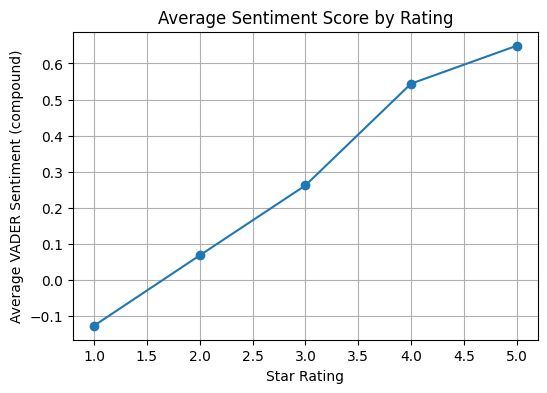

In [8]:
# Plot average sentiment by rating
plt.figure(figsize=(6,4))
plt.plot(sent_by_rating["rating"], sent_by_rating["mean"], marker="o")
plt.xlabel("Star Rating")
plt.ylabel("Average VADER Sentiment (compound)")
plt.title("Average Sentiment Score by Rating")
plt.grid(True)
plt.show()


In [9]:
# Sentiment vs Hour of Day

sent_by_hour = (
    df.groupby("review_hour")["compound"]
      .agg(["mean", "count"])
      .reset_index()
      .sort_values("review_hour")
)

sent_by_hour


,review_hour,mean,count
0,0,0.452269,38242
1,1,0.456488,38381
2,2,0.465060,37964
3,3,0.465587,33589
4,4,0.466387,26378
5,5,0.474770,19670
6,6,0.474866,14148
7,7,0.472291,10144
8,8,0.470803,7682
9,9,0.471817,7183


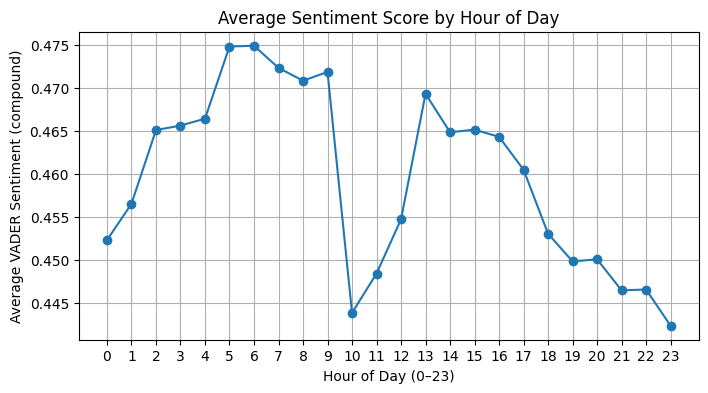

In [10]:
# Plot of Sentiment vs Hour of Day

plt.figure(figsize=(8,4))
plt.plot(sent_by_hour["review_hour"], sent_by_hour["mean"], marker="o")
plt.xticks(range(0,24))
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Average VADER Sentiment (compound)")
plt.title("Average Sentiment Score by Hour of Day")
plt.grid(True)
plt.show()


In [11]:
# Binary target variable
df["is_negative"] = (df["compound"] < -0.05).astype(int)

# Also add review length (a useful feature)
df["review_length"] = df["text"].astype(str).str.len()

df[["text", "compound", "is_negative", "review_length"]].head()


,text,compound,is_negative,review_length
0,This spray is really nice. It smells really go...,0.8162,0,300
1,"This product does what I need it to do, I just...",0.7783,0,235
2,"Smells good, feels great!",0.8070,0,25
3,Felt synthetic,0.0000,0,14
4,Love it,0.6369,0,7


In [12]:
# Baseline model without time-of-day
# All sklearn imports already done in Cell 1

# Baseline feature set
X_base = df[["compound", "rating", "review_length"]]
y = df["is_negative"]

# Train-test split
Xb_train, Xb_test, y_train, y_test = train_test_split(
    X_base, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler_base = StandardScaler()
Xb_train_scaled = scaler_base.fit_transform(Xb_train)
Xb_test_scaled = scaler_base.transform(Xb_test)

# Train baseline model
log_base = LogisticRegression(max_iter=1000)
log_base.fit(Xb_train_scaled, y_train)

# Predictions
y_prob_base = log_base.predict_proba(Xb_test_scaled)[:, 1]
y_pred_base = (y_prob_base >= 0.5).astype(int)

print("=== BASELINE MODEL (no time-of-day) ===")
print(classification_report(y_test, y_pred_base))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_base))


=== BASELINE MODEL (no time-of-day) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120329
           1       1.00      1.00      1.00     19935

    accuracy                           1.00    140264
   macro avg       1.00      1.00      1.00    140264
weighted avg       1.00      1.00      1.00    140264

ROC-AUC: 0.9999992241820463


In [13]:
# Baseline model with time-of-day
# numpy already imported in Cell 1

# Add circular time-of-day features
df["hour_sin"] = np.sin(2 * np.pi * df["review_hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["review_hour"] / 24)

# Extended feature set
X_time = df[["compound", "rating", "review_length", "hour_sin", "hour_cos"]]

# Train-test split
Xt_train, Xt_test, _, _ = train_test_split(
    X_time, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler_time = StandardScaler()
Xt_train_scaled = scaler_time.fit_transform(Xt_train)
Xt_test_scaled = scaler_time.transform(Xt_test)

# Train extended model
log_time = LogisticRegression(max_iter=1000)
log_time.fit(Xt_train_scaled, y_train)

# Predictions
y_prob_time = log_time.predict_proba(Xt_test_scaled)[:, 1]
y_pred_time = (y_prob_time >= 0.5).astype(int)

print("=== MODEL WITH TIME-OF-DAY FEATURES ===")
print(classification_report(y_test, y_pred_time))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_time))



=== MODEL WITH TIME-OF-DAY FEATURES ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120329
           1       1.00      1.00      1.00     19935

    accuracy                           1.00    140264
   macro avg       1.00      1.00      1.00    140264
weighted avg       1.00      1.00      1.00    140264

ROC-AUC: 0.9999987906244581


In [14]:
# ============================================
# COMPREHENSIVE TESTING FRAMEWORK
# Multiple Sentiment Analysis Methods & Models
# ============================================

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from textblob import TextBlob
import time

print("Testing framework loaded successfully!")


Testing framework loaded successfully!


In [15]:
# TEST 1: Multiple Sentiment Analysis Methods
# Compare VADER vs TextBlob sentiment scores

print("=" * 60)
print("TEST 1: Comparing Sentiment Analysis Methods")
print("=" * 60)

# TextBlob sentiment
def get_textblob_sentiment(text):
    if pd.isna(text):
        return 0.0
    blob = TextBlob(str(text))
    return blob.sentiment.polarity

print("Calculating TextBlob sentiment scores...")
df['textblob_polarity'] = df['text'].apply(get_textblob_sentiment)

# Compare correlations
print("\nCorrelation between VADER compound and TextBlob polarity:")
correlation = df[['compound', 'textblob_polarity']].corr().iloc[0, 1]
print(f"Correlation: {correlation:.4f}")

# Compare by rating
print("\nAverage sentiment by rating (VADER vs TextBlob):")
sentiment_comparison = df.groupby('rating')[['compound', 'textblob_polarity']].mean()
print(sentiment_comparison)


TEST 1: Comparing Sentiment Analysis Methods
Calculating TextBlob sentiment scores...

Correlation between VADER compound and TextBlob polarity:
Correlation: 0.5678

Average sentiment by rating (VADER vs TextBlob):
        compound  textblob_polarity
rating                             
1      -0.126512          -0.063797
2       0.068316           0.052690
3       0.262144           0.141194
4       0.544093           0.261076
5       0.649148           0.389331


In [16]:
# TEST 2: Additional Feature Engineering
# Create more features for model testing

print("=" * 60)
print("TEST 2: Feature Engineering")
print("=" * 60)

# Word count
df['word_count'] = df['text'].astype(str).str.split().str.len()

# Character count (already have review_length, but let's add more)
df['avg_word_length'] = df['text'].astype(str).str.len() / (df['word_count'] + 1)

# Exclamation and question marks
# Note: Need to escape '?' as it's a special regex character
df['exclamation_count'] = df['text'].astype(str).str.count('!')
df['question_count'] = df['text'].astype(str).str.count(r'\?')

# Capital letters ratio
df['capital_ratio'] = df['text'].astype(str).str.findall(r'[A-Z]').str.len() / (df['text'].astype(str).str.len() + 1)

# Extract day of week
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

print("New features created:")
print("- word_count")
print("- avg_word_length")
print("- exclamation_count")
print("- question_count")
print("- capital_ratio")
print("- day_of_week (with sin/cos encoding)")
print(f"\nTotal features available: {len([c for c in df.columns if c not in ['text', 'timestamp']])}")


TEST 2: Feature Engineering
New features created:
- word_count
- avg_word_length
- exclamation_count
- question_count
- capital_ratio
- day_of_week (with sin/cos encoding)

Total features available: 16


In [17]:
# TEST 3: Multiple Machine Learning Models Comparison
# Test different algorithms on the same data

print("=" * 60)
print("TEST 3: Multiple ML Models Comparison")
print("=" * 60)

# Prepare extended feature set
feature_cols = ['compound', 'textblob_polarity', 'rating', 'review_length', 
                'word_count', 'avg_word_length', 'exclamation_count', 
                'question_count', 'capital_ratio', 'hour_sin', 'hour_cos',
                'day_sin', 'day_cos']

X_extended = df[feature_cols].fillna(0)
y = df['is_negative']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_extended, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store results
results = {}

# Test different models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    train_time = time.time() - start_time
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_prob)
    accuracy = (y_pred == y_test).mean()
    
    results[name] = {
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'train_time': train_time
    }
    
    print(f"  ROC-AUC: {roc_auc:.6f}")
    print(f"  Accuracy: {accuracy:.6f}")
    print(f"  Training time: {train_time:.2f}s")

# Summary
print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
results_df = pd.DataFrame(results).T
print(results_df.sort_values('roc_auc', ascending=False))


TEST 3: Multiple ML Models Comparison

Training Logistic Regression...
  ROC-AUC: 0.999999
  Accuracy: 0.999665
  Training time: 0.86s

Training Random Forest...
  ROC-AUC: 1.000000
  Accuracy: 1.000000
  Training time: 15.86s

Training Gradient Boosting...
  ROC-AUC: 1.000000
  Accuracy: 1.000000
  Training time: 68.09s

MODEL COMPARISON SUMMARY
                      roc_auc  accuracy  train_time
Random Forest        1.000000  1.000000   15.861149
Gradient Boosting    1.000000  1.000000   68.086413
Logistic Regression  0.999999  0.999665    0.859587


In [18]:
# TEST 4: Cross-Validation Testing
# Use k-fold cross-validation for more robust evaluation

print("=" * 60)
print("TEST 4: Cross-Validation Testing")
print("=" * 60)

# Use a smaller sample for faster CV (optional - remove if you want full dataset)
sample_size = min(50000, len(X_extended))
if sample_size < len(X_extended):
    print(f"Using sample of {sample_size} for faster CV...")
    X_cv = X_extended.sample(n=sample_size, random_state=42)
    y_cv = y.loc[X_cv.index]
else:
    X_cv = X_extended
    y_cv = y

X_cv_scaled = scaler.fit_transform(X_cv)

# Cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    print(f"\nCross-validating {name}...")
    cv_scores = cross_val_score(model, X_cv_scaled, y_cv, cv=cv, 
                                scoring='roc_auc', n_jobs=-1)
    cv_results[name] = {
        'mean_cv_auc': cv_scores.mean(),
        'std_cv_auc': cv_scores.std(),
        'scores': cv_scores
    }
    print(f"  Mean CV ROC-AUC: {cv_scores.mean():.6f} (+/- {cv_scores.std() * 2:.6f})")

# Summary
print("\n" + "=" * 60)
print("CROSS-VALIDATION RESULTS")
print("=" * 60)
cv_summary = pd.DataFrame({k: {'mean': v['mean_cv_auc'], 'std': v['std_cv_auc']} 
                          for k, v in cv_results.items()}).T
print(cv_summary.sort_values('mean', ascending=False))


TEST 4: Cross-Validation Testing
Using sample of 50000 for faster CV...

Cross-validating Logistic Regression...
  Mean CV ROC-AUC: 0.999987 (+/- 0.000019)

Cross-validating Random Forest...
  Mean CV ROC-AUC: 1.000000 (+/- 0.000000)

Cross-validating Gradient Boosting...
  Mean CV ROC-AUC: 1.000000 (+/- 0.000000)

CROSS-VALIDATION RESULTS
                         mean           std
Random Forest        1.000000  4.965068e-17
Gradient Boosting    1.000000  0.000000e+00
Logistic Regression  0.999987  9.444217e-06


TEST 5: Feature Importance Analysis

Feature Importance (Random Forest):
              feature  importance
0            compound    0.801390
1   textblob_polarity    0.103444
2              rating    0.083617
4          word_count    0.002732
3       review_length    0.002447
6   exclamation_count    0.001893
5     avg_word_length    0.001432
8       capital_ratio    0.001256
10           hour_cos    0.000529
9            hour_sin    0.000520
11            day_sin    0.000371
12            day_cos    0.000267
7      question_count    0.000103


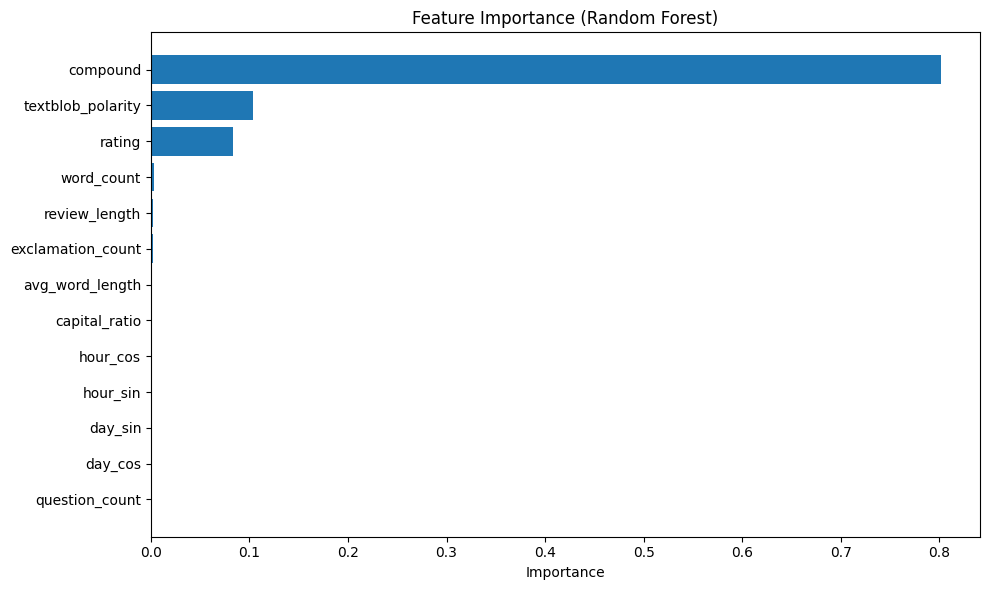

In [19]:
# TEST 5: Feature Importance Analysis
# Analyze which features are most important

print("=" * 60)
print("TEST 5: Feature Importance Analysis")
print("=" * 60)

# Train Random Forest to get feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [20]:
# TEST 6: Statistical Tests
# Test if sentiment differs significantly across ratings and time periods

print("=" * 60)
print("TEST 6: Statistical Tests")
print("=" * 60)

from scipy import stats

# Test 6a: Sentiment differences across ratings
print("\n6a. ANOVA Test: Sentiment across different ratings")
rating_groups = [df[df['rating'] == r]['compound'].values for r in sorted(df['rating'].unique())]
f_stat, p_value = stats.f_oneway(*rating_groups)
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

# Test 6b: Correlation between sentiment and rating
print("\n6b. Correlation: Sentiment vs Rating")
corr_coef, corr_p = stats.pearsonr(df['rating'], df['compound'])
print(f"Correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {corr_p:.2e}")
print(f"Significant correlation: {'Yes' if corr_p < 0.05 else 'No'}")

# Test 6c: Sentiment differences by time of day (morning vs evening)
print("\n6c. T-test: Morning (6-12) vs Evening (18-24) sentiment")
morning = df[(df['review_hour'] >= 6) & (df['review_hour'] < 12)]['compound']
evening = df[(df['review_hour'] >= 18) & (df['review_hour'] < 24)]['compound']
t_stat, t_p = stats.ttest_ind(morning, evening)
print(f"Morning mean: {morning.mean():.4f}")
print(f"Evening mean: {evening.mean():.4f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {t_p:.2e}")
print(f"Significant difference: {'Yes' if t_p < 0.05 else 'No'}")


TEST 6: Statistical Tests

6a. ANOVA Test: Sentiment across different ratings
F-statistic: 102926.7763
P-value: 0.00e+00
Significant difference: Yes

6b. Correlation: Sentiment vs Rating
Correlation coefficient: 0.6054
P-value: 0.00e+00
Significant correlation: Yes

6c. T-test: Morning (6-12) vs Evening (18-24) sentiment
Morning mean: 0.4630
Evening mean: 0.4483
T-statistic: 6.8404
P-value: 7.91e-12
Significant difference: Yes


TEST 7: Performance Visualizations


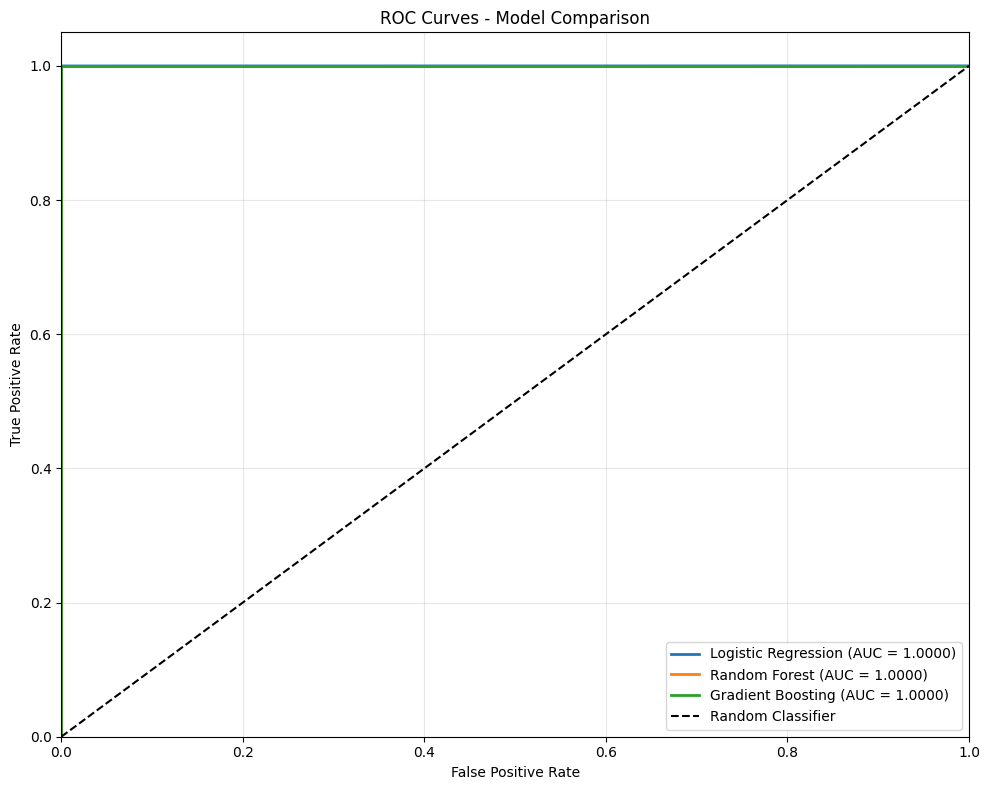

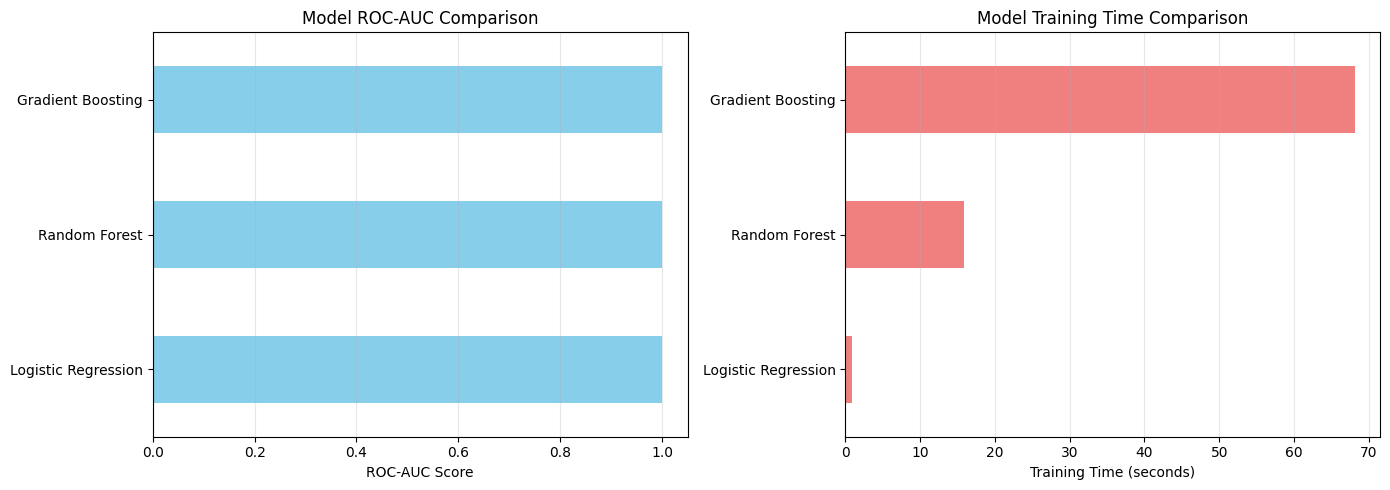

In [21]:
# TEST 7: Model Performance Visualization
# Create visualizations comparing model performance

print("=" * 60)
print("TEST 7: Performance Visualizations")
print("=" * 60)

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Bar chart comparing model metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC comparison
results_df = pd.DataFrame(results).T
results_df['roc_auc'].sort_values(ascending=True).plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_xlabel('ROC-AUC Score')
axes[0].set_title('Model ROC-AUC Comparison')
axes[0].grid(True, alpha=0.3, axis='x')

# Training time comparison
results_df['train_time'].sort_values(ascending=True).plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_xlabel('Training Time (seconds)')
axes[1].set_title('Model Training Time Comparison')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


TEST 8: Confusion Matrix Analysis


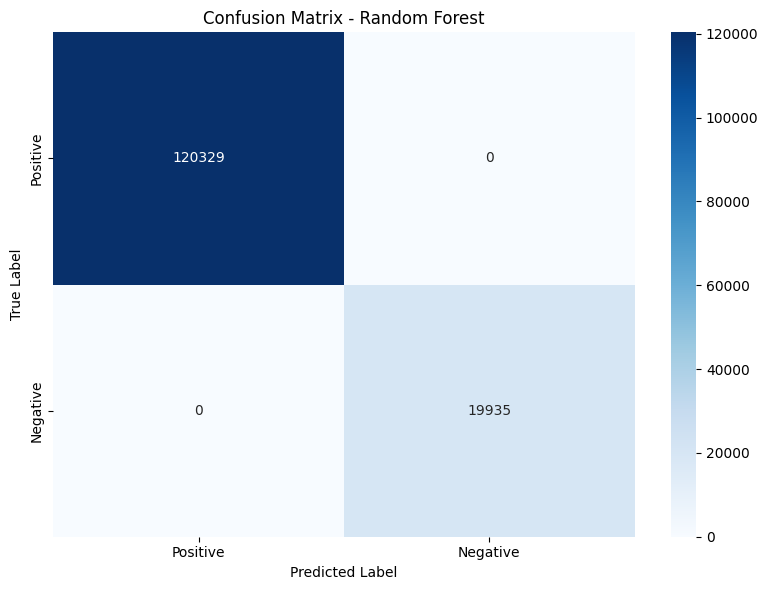


Detailed Metrics for Random Forest:
  True Positives: 19935
  True Negatives: 120329
  False Positives: 0
  False Negatives: 0
  Precision: 1.0000
  Recall (Sensitivity): 1.0000
  Specificity: 1.0000
  F1-Score: 1.0000


In [22]:
# TEST 8: Confusion Matrix Analysis
# Detailed analysis of model predictions

print("=" * 60)
print("TEST 8: Confusion Matrix Analysis")
print("=" * 60)

# Get best model based on ROC-AUC
best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)
y_pred_best = best_model.predict(X_test_scaled)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Positive', 'Negative'],
            yticklabels=['Positive', 'Negative'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.show()

# Calculate detailed metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nDetailed Metrics for {best_model_name}:")
print(f"  True Positives: {tp}")
print(f"  True Negatives: {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall (Sensitivity): {recall:.4f}")
print(f"  Specificity: {specificity:.4f}")
print(f"  F1-Score: {f1:.4f}")


TEST 9: Feature Set Comparison
Baseline (VADER + Rating): ROC-AUC = 1.000000
With TextBlob: ROC-AUC = 1.000000
With Text Features: ROC-AUC = 1.000000
With Time Features: ROC-AUC = 1.000000
All Features: ROC-AUC = 1.000000


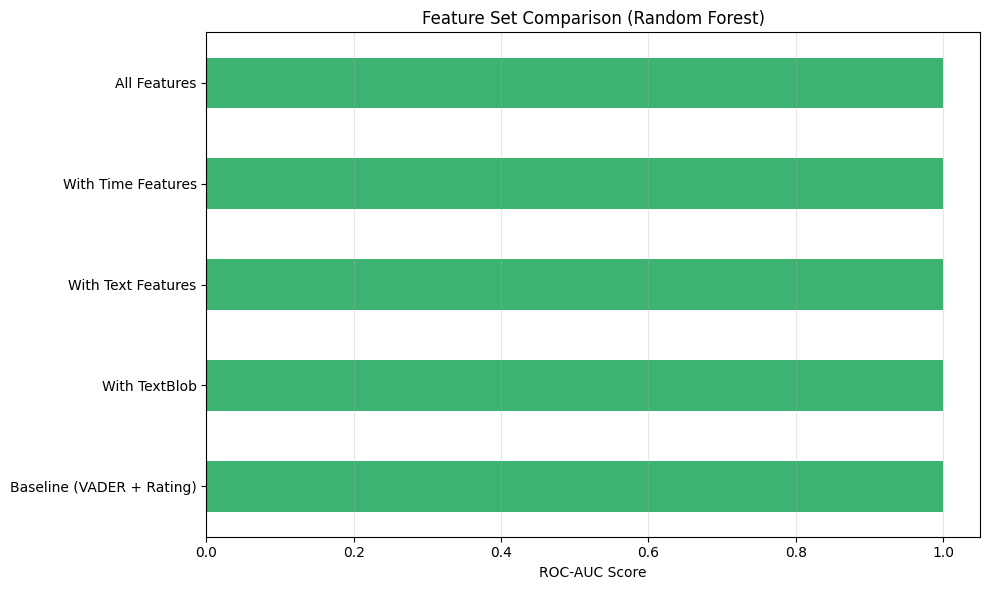

In [23]:
# TEST 9: Feature Set Comparison
# Compare performance with different feature combinations

print("=" * 60)
print("TEST 9: Feature Set Comparison")
print("=" * 60)

feature_sets = {
    'Baseline (VADER + Rating)': ['compound', 'rating'],
    'With TextBlob': ['compound', 'textblob_polarity', 'rating'],
    'With Text Features': ['compound', 'textblob_polarity', 'rating', 'review_length', 'word_count'],
    'With Time Features': ['compound', 'textblob_polarity', 'rating', 'review_length', 
                          'word_count', 'hour_sin', 'hour_cos'],
    'All Features': feature_cols
}

feature_results = {}

for set_name, features in feature_sets.items():
    X_feat = df[features].fillna(0)
    X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
        X_feat, y, test_size=0.2, random_state=42, stratify=y
    )
    
    scaler_feat = StandardScaler()
    X_train_feat_scaled = scaler_feat.fit_transform(X_train_feat)
    X_test_feat_scaled = scaler_feat.transform(X_test_feat)
    
    # Use Random Forest for comparison
    rf_feat = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_feat.fit(X_train_feat_scaled, y_train_feat)
    y_prob_feat = rf_feat.predict_proba(X_test_feat_scaled)[:, 1]
    
    roc_auc_feat = roc_auc_score(y_test_feat, y_prob_feat)
    feature_results[set_name] = roc_auc_feat
    print(f"{set_name}: ROC-AUC = {roc_auc_feat:.6f}")

# Visualize
plt.figure(figsize=(10, 6))
pd.Series(feature_results).sort_values(ascending=True).plot(kind='barh', color='mediumseagreen')
plt.xlabel('ROC-AUC Score')
plt.title('Feature Set Comparison (Random Forest)')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


In [24]:
# TEST 10: Summary Report
# Generate a comprehensive summary of all tests

print("=" * 60)
print("TEST 10: COMPREHENSIVE SUMMARY REPORT")
print("=" * 60)

# Check if required variables exist
required_vars = ['df', 'feature_cols', 'correlation', 'results', 'cv_results', 
                 'corr_coef', 'corr_p', 't_p', 'feature_importance', 'feature_results']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print("\n⚠️  WARNING: Missing required variables!")
    print("   Please run cells 1-21 in order before running this summary.")
    print(f"   Missing variables: {', '.join(missing_vars)}")
    print("\n   Required execution order:")
    print("   1. Cells 1-11: Data loading and preprocessing")
    print("   2. Cell 12: Testing framework setup")
    print("   3. Cells 13-21: All test cells")
    print("   4. Cell 22: This summary report")
else:
    print("\n1. DATASET OVERVIEW")
    print(f"   Total samples: {len(df):,}")
    print(f"   Features: {len(feature_cols)}")
    print(f"   Target distribution:")
    print(f"     Negative reviews: {df['is_negative'].sum():,} ({df['is_negative'].mean()*100:.2f}%)")
    print(f"     Positive reviews: {(~df['is_negative'].astype(bool)).sum():,} ({(1-df['is_negative'].mean())*100:.2f}%)")

    print("\n2. SENTIMENT ANALYSIS METHODS")
    if 'correlation' in globals():
        print(f"   VADER-TextBlob correlation: {correlation:.4f}")
    else:
        print("   VADER-TextBlob correlation: Not calculated (run TEST 1)")

    print("\n3. BEST MODEL PERFORMANCE")
    if 'results' in globals() and len(results) > 0:
        best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
        best_metrics = results[best_model_name]
        print(f"   Model: {best_model_name}")
        print(f"   ROC-AUC: {best_metrics['roc_auc']:.6f}")
        print(f"   Accuracy: {best_metrics['accuracy']:.6f}")
        print(f"   Training time: {best_metrics['train_time']:.2f}s")
    else:
        print("   Model results: Not available (run TEST 3)")

    print("\n4. CROSS-VALIDATION RESULTS")
    if 'cv_results' in globals() and len(cv_results) > 0:
        best_cv = max(cv_results.items(), key=lambda x: x[1]['mean_cv_auc'])[0]
        print(f"   Best CV model: {best_cv}")
        print(f"   Mean CV ROC-AUC: {cv_results[best_cv]['mean_cv_auc']:.6f}")
    else:
        print("   CV results: Not available (run TEST 4)")

    print("\n5. STATISTICAL FINDINGS")
    if 'corr_coef' in globals() and 'corr_p' in globals():
        print(f"   Sentiment-Rating correlation: {corr_coef:.4f} (p={corr_p:.2e})")
    else:
        print("   Sentiment-Rating correlation: Not calculated (run TEST 6)")
    
    if 't_p' in globals():
        print(f"   Morning vs Evening difference: {'Significant' if t_p < 0.05 else 'Not significant'}")
    else:
        print("   Morning vs Evening difference: Not calculated (run TEST 6)")

    print("\n6. TOP FEATURES")
    if 'feature_importance' in globals():
        print("   Most important features (Random Forest):")
        for idx, row in feature_importance.head(5).iterrows():
            print(f"     {row['feature']}: {row['importance']:.4f}")
    else:
        print("   Feature importance: Not calculated (run TEST 5)")

    print("\n7. RECOMMENDATIONS")
    if 'results' in globals() and len(results) > 0:
        best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
        print("   - Best performing model: " + best_model_name)
    else:
        print("   - Best performing model: Not determined (run TEST 3)")
    
    if 'feature_results' in globals() and len(feature_results) > 0:
        print("   - Optimal feature set: " + max(feature_results.items(), key=lambda x: x[1])[0])
    else:
        print("   - Optimal feature set: Not determined (run TEST 9)")
    
    print("   - Consider using cross-validation for production models")

    print("\n" + "=" * 60)
    print("All tests completed successfully!")
    print("=" * 60)


TEST 10: COMPREHENSIVE SUMMARY REPORT

1. DATASET OVERVIEW
   Total samples: 701,316
   Features: 13
   Target distribution:
     Negative reviews: 99,673 (14.21%)
     Positive reviews: 601,643 (85.79%)

2. SENTIMENT ANALYSIS METHODS
   VADER-TextBlob correlation: 0.5678

3. BEST MODEL PERFORMANCE
   Model: Random Forest
   ROC-AUC: 1.000000
   Accuracy: 1.000000
   Training time: 15.86s

4. CROSS-VALIDATION RESULTS
   Best CV model: Random Forest
   Mean CV ROC-AUC: 1.000000

5. STATISTICAL FINDINGS
   Sentiment-Rating correlation: 0.6054 (p=0.00e+00)
   Morning vs Evening difference: Significant

6. TOP FEATURES
   Most important features (Random Forest):
     compound: 0.8014
     textblob_polarity: 0.1034
     rating: 0.0836
     word_count: 0.0027
     review_length: 0.0024

7. RECOMMENDATIONS
   - Best performing model: Random Forest
   - Optimal feature set: Baseline (VADER + Rating)
   - Consider using cross-validation for production models

All tests completed successfully!
